# Create images of geophysical data from NASA OceanColor Web
Steps:
1. Download data from https://oceancolor.gsfc.nasa.gov/ browser
2. Load in Python using xarray
3. Examine file attributes
4. Extract desired groups (e.g., geophysical_data, navigation_data)
5. Extract specific variables (e.g., chl-a, Rrs values for each wavelength, etc.)
6. Plot using matplotlib
7. Save

In [1]:
import os
import xarray as xr
# import datatree

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import cmocean
from netCDF4 import Dataset

This script uses NetCDF data wrangling similar to Patrick Gray's sample code in https://github.com/pydata/xarray/issues/3996

In [2]:
# Southeast after Ian for paper; comment/uncomment next two lines
filename = 'SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc' # Southeast US, 1-Oct-22
savename = 'Savannah-October1st-2022'

# SF Bay/West Coast for paper; comment/uncomment next two lines
# filename = 'SEAHAWK1_HAWKEYE.20220903T183420.L2.OC.nc' # SF, 3-Sep-22
# savename = 'SanFrancisco-MontereyBay-September3rd-2022'

# Raw data from SeaDAS kept in directory above git repo due to large file sizes
file = os.path.join('../L2_data_from_seadas', filename)

# Load the dataset using xarray
xds = xr.open_dataset(file)
xds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

### Start L2 data wrangling and viz here

In [3]:
dataset = Dataset(file)
print(dataset.groups)

{'sensor_band_parameters': <class 'netCDF4._netCDF4.Group'>
group /sensor_band_parameters:
    dimensions(sizes): 
    variables(dimensions): int32 wavelength(number_of_bands), float32 vcal_gain(number_of_reflective_bands), float32 vcal_offset(number_of_reflective_bands), float32 F0(number_of_reflective_bands), float32 aw(number_of_reflective_bands), float32 bbw(number_of_reflective_bands), float32 k_oz(number_of_reflective_bands), float32 k_no2(number_of_reflective_bands), float32 Tau_r(number_of_reflective_bands)
    groups: , 'scan_line_attributes': <class 'netCDF4._netCDF4.Group'>
group /scan_line_attributes:
    dimensions(sizes): 
    variables(dimensions): int32 year(number_of_lines), int32 day(number_of_lines), int32 msec(number_of_lines), int8 detnum(number_of_lines), int8 mside(number_of_lines), float32 slon(number_of_lines), float32 clon(number_of_lines), float32 elon(number_of_lines), float32 slat(number_of_lines), float32 clat(number_of_lines), float32 elat(number_of_lines

In [4]:
gd = dataset.groups['geophysical_data']
nav = dataset.groups['navigation_data']
lons = nav.variables["longitude"][:]
lats = nav.variables["latitude"][:]

flags = gd.variables["l2_flags"][:]

# this has the data we want!
print(gd.variables.keys())

dict_keys(['aot_867', 'angstrom', 'Rrs_412', 'Rrs_447', 'Rrs_488', 'Rrs_510', 'Rrs_556', 'Rrs_670', 'chlor_a', 'Kd_490', 'pic', 'poc', 'l2_flags'])


### Chl-a
Manually pull geophysical data variables (e.g., in the next code chunk, chlorophyll-a), create a new xarray dataset of that variable with lat/lon added, and push this back into the main xarray dataset where data aren't flagged. Plotting routines will pull variables back out of main xarray dataset. Repeat for all desired variables

In [5]:
# we can create the correct xds with the data from netcdf4
chl_xds = xr.Dataset({'chlor_a':(('x', 'y'),gd.variables['chlor_a'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Chlorophyll-a'})

# then merge back into the xarray dataset with all the attributes
xds['chlor_a'] = chl_xds.chlor_a
# replace nodata areas with nan
xds = xds.where(xds['chlor_a'] != -32767.0)

xds

<xarray.Dataset>
Dimensions:    (x: 5936, y: 1800)
Coordinates:
    latitude   (x, y) float32 34.4 34.4 34.4 34.4 ... 27.31 27.31 27.31 27.31
    longitude  (x, y) float32 -80.47 -80.47 -80.47 ... -79.51 -79.51 -79.5
Dimensions without coordinates: x, y
Data variables:
    chlor_a    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

### Kd_490

In [6]:
# Add Kd_490 also
Kd_490_xds = xr.Dataset({'Kd_490':(('x', 'y'),gd.variables['Kd_490'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Kd_490 [m^-1]'})

# then merge back into the xarray dataset with all the attributes
xds['Kd_490'] = Kd_490_xds.Kd_490
# replace nodata areas with nan
xds['Kd_490'] = xds['Kd_490'].where(xds['Kd_490'] != -32767.0)
xds['Kd_490'] = xds['Kd_490'].where(xds['Kd_490'] != 32767.0)

xds

<xarray.Dataset>
Dimensions:    (x: 5936, y: 1800)
Coordinates:
    latitude   (x, y) float32 34.4 34.4 34.4 34.4 ... 27.31 27.31 27.31 27.31
    longitude  (x, y) float32 -80.47 -80.47 -80.47 ... -79.51 -79.51 -79.5
Dimensions without coordinates: x, y
Data variables:
    chlor_a    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Kd_490     (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

### Rrs_412

In [7]:
# Rrs
Rrs_412_xds = xr.Dataset({'Rrs_412':(('x', 'y'),gd.variables['Rrs_412'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_412'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_412'] = Rrs_412_xds.Rrs_412
# replace nodata areas with nan
xds['Rrs_412'] = xds['Rrs_412'].where(xds['Rrs_412'] != -32767.0)
xds['Rrs_412'] = xds['Rrs_412'].where(xds['Rrs_412'] != 32767.0)

xds

<xarray.Dataset>
Dimensions:    (x: 5936, y: 1800)
Coordinates:
    latitude   (x, y) float32 34.4 34.4 34.4 34.4 ... 27.31 27.31 27.31 27.31
    longitude  (x, y) float32 -80.47 -80.47 -80.47 ... -79.51 -79.51 -79.5
Dimensions without coordinates: x, y
Data variables:
    chlor_a    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Kd_490     (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_412    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

### 'Rrs_447', 'Rrs_488', 'Rrs_510', 'Rrs_556', 'Rrs_670'

In [8]:
##################################################################################
# Rrs_447
Rrs_447_xds = xr.Dataset({'Rrs_447':(('x', 'y'),gd.variables['Rrs_447'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_447'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_447'] = Rrs_447_xds.Rrs_447
# replace nodata areas with nan
xds['Rrs_447'] = xds['Rrs_447'].where(xds['Rrs_447'] != -32767.0)
xds['Rrs_447'] = xds['Rrs_447'].where(xds['Rrs_447'] != 32767.0)

##################################################################################
# Rrs_488
Rrs_488_xds = xr.Dataset({'Rrs_488':(('x', 'y'),gd.variables['Rrs_488'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_488'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_488'] = Rrs_488_xds.Rrs_488
# replace nodata areas with nan
xds['Rrs_488'] = xds['Rrs_488'].where(xds['Rrs_488'] != -32767.0)
xds['Rrs_488'] = xds['Rrs_488'].where(xds['Rrs_488'] != 32767.0)

##################################################################################
# Rrs_510
Rrs_510_xds = xr.Dataset({'Rrs_510':(('x', 'y'),gd.variables['Rrs_510'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_510'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_510'] = Rrs_510_xds.Rrs_510
# replace nodata areas with nan
xds['Rrs_510'] = xds['Rrs_510'].where(xds['Rrs_510'] != -32767.0)
xds['Rrs_510'] = xds['Rrs_510'].where(xds['Rrs_510'] != 32767.0)

##################################################################################
# Rrs_556
Rrs_556_xds = xr.Dataset({'Rrs_556':(('x', 'y'),gd.variables['Rrs_556'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_556'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_556'] = Rrs_556_xds.Rrs_556
# replace nodata areas with nan
xds['Rrs_556'] = xds['Rrs_556'].where(xds['Rrs_556'] != -32767.0)
xds['Rrs_556'] = xds['Rrs_556'].where(xds['Rrs_556'] != 32767.0)

##################################################################################
# Rrs_670
Rrs_670_xds = xr.Dataset({'Rrs_670':(('x', 'y'),gd.variables['Rrs_670'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Rrs_670'})

# then merge back into the xarray dataset with all the attributes
xds['Rrs_670'] = Rrs_670_xds.Rrs_670
# replace nodata areas with nan
xds['Rrs_670'] = xds['Rrs_670'].where(xds['Rrs_670'] != -32767.0)
xds['Rrs_670'] = xds['Rrs_670'].where(xds['Rrs_670'] != 32767.0)


In [9]:
# Add POC also
poc_xds = xr.Dataset({'poc':(('x', 'y'),gd.variables['poc'][:].data)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'poc [mg m^-3]'})

# then merge back into the xarray dataset with all the attributes
xds['poc'] = poc_xds.poc
# replace nodata areas with nan
xds['poc'] = xds['poc'].where(xds['poc'] != -32767.0)
xds['poc'] = xds['poc'].where(xds['poc'] != 32767.0)

xds

<xarray.Dataset>
Dimensions:    (x: 5936, y: 1800)
Coordinates:
    latitude   (x, y) float32 34.4 34.4 34.4 34.4 ... 27.31 27.31 27.31 27.31
    longitude  (x, y) float32 -80.47 -80.47 -80.47 ... -79.51 -79.51 -79.5
Dimensions without coordinates: x, y
Data variables:
    chlor_a    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Kd_490     (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_412    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_447    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_488    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_510    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_556    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_670    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    poc        (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

### Simple cropping/slicing code in case a subset of image is desired.
Unused. Leave commented out, and set `cropped_ds = xds` to use full file.

In [10]:
# Subset/slice
# min_lon = -24.995 
# min_x = 800
# max_lon = 45.50 
# max_y = 3000 

# make cropped_ds = xds for no slicing
# cropped_ds = xds.sel(x=slice(min_x,max_y))#, lon=slice(min_lon,max_lon))
cropped_ds = xds

cropped_ds

<xarray.Dataset>
Dimensions:    (x: 5936, y: 1800)
Coordinates:
    latitude   (x, y) float32 34.4 34.4 34.4 34.4 ... 27.31 27.31 27.31 27.31
    longitude  (x, y) float32 -80.47 -80.47 -80.47 ... -79.51 -79.51 -79.5
Dimensions without coordinates: x, y
Data variables:
    chlor_a    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Kd_490     (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_412    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_447    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_488    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_510    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_556    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Rrs_670    (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    poc        (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/46)
    title:                          HAWKEYE Level-2 Data
    product_name:                   SEAHAWK1_HAWKEYE.20221001T152646.L2.OC.nc
    processing_version:             2018.0
    history:                        l2gen par=/data2/sdpsoper/vdc/vpu1/workbu...
    instrument:                     HAWKEYE
    platform:                       Seahawk1
    ...                             ...
    geospatial_lon_max:             -77.69664
    geospatial_lon_min:             -82.080574
    startDirection:                 Descending
    endDirection:                   Descending
    day_night_flag:                 Day
    earth_sun_distance_correction:  0.9977095127105713

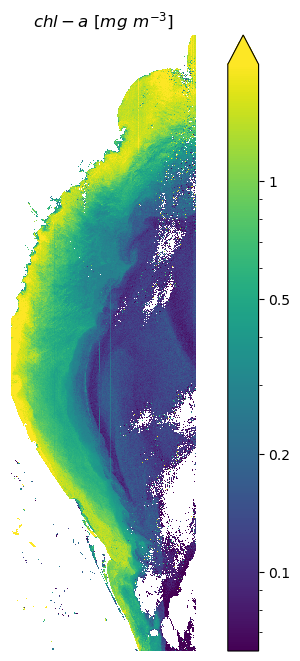

In [11]:
# Plot chl-a
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))
# fig, ax = plt.subplots(frameon = False, figsize = (3, 10))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = cmocean.cm.algae
cax = cropped_ds.chlor_a.plot(robust=True, norm=matplotlib.colors.LogNorm(), add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$chl-a\ [mg\ m^{-3}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5] # savannah
# ticks = [0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4] # sanfrancisco
cbar = fig.colorbar(cax, fraction=0.13, extend="max", ticks=ticks)#, location="bottom")
cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('chl-a [µg/L]')

#Save figure
fig_fname_chl = savename+'_chla.png'
fig_file_chl = os.path.join('L2_figs', fig_fname_chl)
plt.savefig(fig_file_chl, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

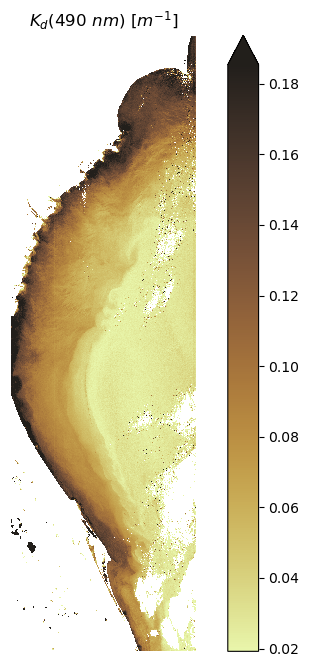

In [12]:
# Plot Kd_490
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = cmocean.cm.turbid
cax = xds.Kd_490.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')


ax.set_title(r'$K_d(490\ nm)\ [m^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.12, extend="max", location = "right")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Kd_490 [m^-1]')

#Save figure
fig_fname_chl = savename+'_Kd_490.png'
fig_file_chl = os.path.join('L2_figs', fig_fname_chl)
plt.savefig(fig_file_chl, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_412'**

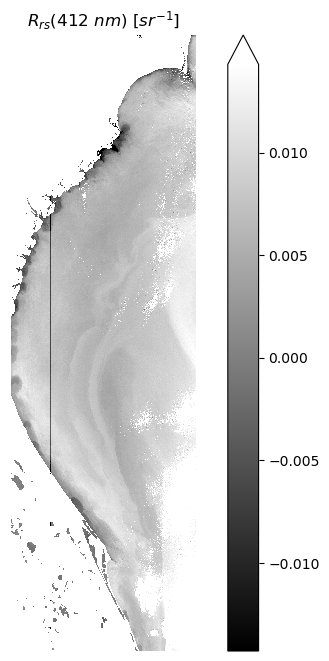

In [13]:
# Plot Rrs_412
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_412.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(412\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.13, extend="max")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_412')

# Save figure
fig_fname_Rrs_412 = savename+'_Rrs_412.png'
fig_file_Rrs_412 = os.path.join('L2_figs', fig_fname_Rrs_412)
plt.savefig(fig_file_Rrs_412, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_447'**

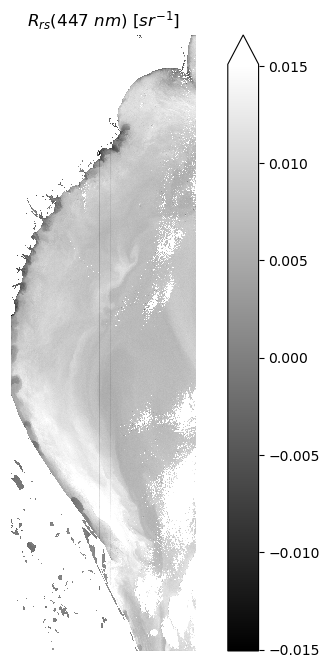

In [14]:
# Plot Rrs_447
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_447.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(447\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.13, extend="max")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_447')

# Save figure
fig_fname_Rrs_447 = savename+'_Rrs_447.png'
fig_file_Rrs_447 = os.path.join('L2_figs', fig_fname_Rrs_447)
plt.savefig(fig_file_Rrs_447, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_488'**

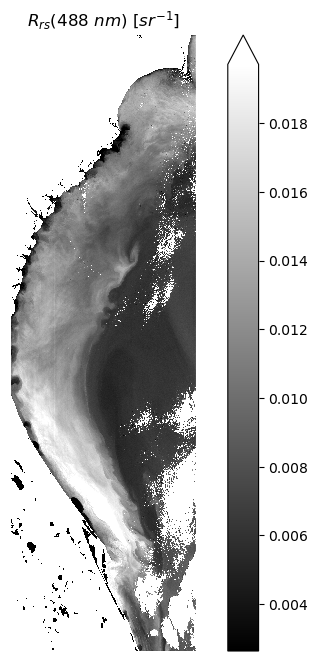

In [15]:
# Plot Rrs_488
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_488.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(488\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.13, extend="max")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_488')

# Save figure
fig_fname_Rrs_488 = savename+'_Rrs_488.png'
fig_file_Rrs_488 = os.path.join('L2_figs', fig_fname_Rrs_488)
plt.savefig(fig_file_Rrs_488, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_510'**

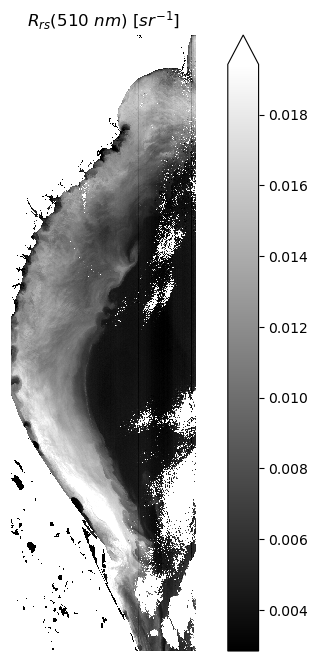

In [16]:
# Plot Rrs_510
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_510.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(510\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.13, extend="max")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_510')

# Save figure
fig_fname_Rrs_510 = savename+'_Rrs_510.png'
fig_file_Rrs_510 = os.path.join('L2_figs', fig_fname_Rrs_510)
plt.savefig(fig_file_Rrs_510, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_556'**

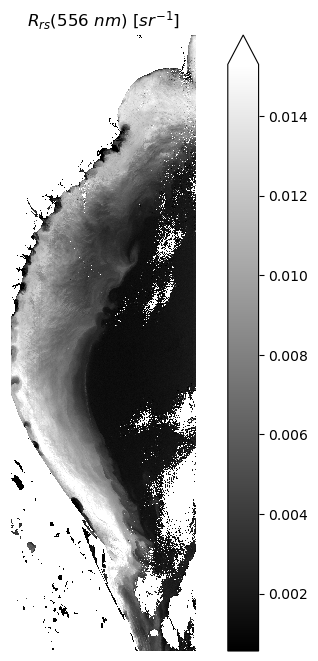

In [17]:
# Plot Rrs_556
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_556.plot(robust=True, cmap = cmap, add_colorbar=False)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(556\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
# ticks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
cbar = fig.colorbar(cax, fraction=0.13, extend="max")#, ticks=ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_556')

# Save figure
fig_fname_Rrs_556 = savename+'_Rrs_556.png'
fig_file_Rrs_556 = os.path.join('L2_figs', fig_fname_Rrs_556)
plt.savefig(fig_file_Rrs_556, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

### **'Rrs_670'**

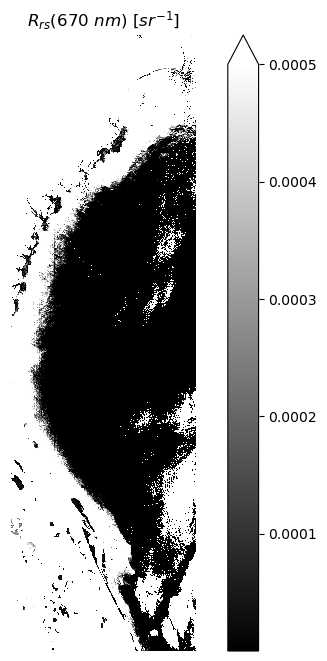

In [18]:
# Plot Rrs_670
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = 'gray'
cax = cropped_ds.Rrs_670.plot(robust=True, cmap = cmap, add_colorbar=False, vmax = 0.0005)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$R_{rs}(670\ nm)\ [sr^{-1}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
ticks = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
cbar = fig.colorbar(cax, fraction=0.13, extend="max", ticks=ticks)
cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('Rrs_670')

# Save figure
fig_fname_Rrs_670 = savename+'_Rrs_670.png'
fig_file_Rrs_670 = os.path.join('L2_figs', fig_fname_Rrs_670)
plt.savefig(fig_file_Rrs_670, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)

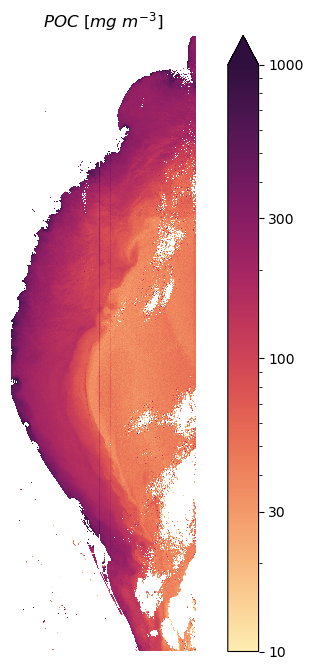

In [19]:
# Plot POC
fig, ax = plt.subplots(frameon = False, figsize = (8, 8))

# Use robust = True to use the 2nd and 98th percentiles of the data to compute the color limits
cmap = cmocean.cm.matter
cax = cropped_ds.poc.plot(cmap = cmap, add_colorbar=False, norm=matplotlib.colors.LogNorm(), vmin = 10, vmax = 1000)
plt.gca().invert_yaxis()
ax.axes.set_aspect('equal')

ax.set_title(r'$POC\ [mg\ m^{-3}]$')

plt.axis('off') # get rid of bounding box for pasting onto true color image

# Change ticks
ticks = [1, 3, 10, 30, 100, 300, 1000]
cbar = fig.colorbar(cax, fraction=0.13, extend="max", ticks=ticks)
cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_ylabel('POC [mg m^-3]')

# Save figure
fig_fname_poc = savename+'_poc.png'
fig_file_poc = os.path.join('L2_figs', fig_fname_poc)
plt.savefig(fig_file_poc, dpi = 600, transparent=True, bbox_inches='tight', pad_inches=0)